<a href="https://colab.research.google.com/github/Vcarmelli/Peptide-Generation/blob/main/Model_Trials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install hf_xet --quiet
!pip install transformers peft accelerate bitsandbytes --quiet
!pip install nltk --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.7 MB/s eta 0:00:00


In [ ]:
#@title Pre-process data
import pandas as pd

csv_folder = "/content/drive/MyDrive/csv/Final Datasets"
df = pd.read_csv(f'{csv_folder}/peptides_with_labels.csv')

def preprocess(row):
    target = row["Target"]
    sequence = ' '.join(list(row["Sequence"]))  # space between amino acids
    inhibition = row["IC50"] if pd.notna(row["IC50"]) else 0
    return pd.Series([target, sequence, inhibition])

df[['Target', 'Peptide', 'Inhibition']] = df.apply(preprocess, axis=1)
df = df[['Target', 'Peptide', 'Inhibition']]
df.head()

,Target,Peptide,Inhibition
0,1,G Q G K A H N G R L I T A N P,33.0
1,2,G Q G K A H N G R L I T A N P,10.0
2,3,G Q G K A H N G R L I T A N P,20.0
3,4,G Q G K A H N G R L I T A N P,20.0
4,1,D R G W G N G C G L F G,10.0


In [ ]:
#@title Load Model and LORA Adapters

from transformers import T5Tokenizer, T5ForConditionalGeneration, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType # Parameter-efficient fine-tuning (peft)

bnb_config = BitsAndBytesConfig(load_in_8bit=True)  # memory saver load model in lower bit
model = T5ForConditionalGeneration.from_pretrained(
    "Rostlab/prot_t5_xl_uniref50",
    quantization_config=bnb_config,
    device_map="auto"
)
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False)

# Apply LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM,
    target_modules=["q", "v"]  # typical for T5 attention
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


trainable params: 5,898,240 || all params: 2,824,728,576 || trainable%: 0.2088


In [ ]:
#@title Build Dataset
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torch

class PeptideDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.inputs = dataframe['Target'].tolist()
        self.peptides = dataframe['Peptide'].tolist()
        self.inhibitions = dataframe['Inhibition'].tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_text = f"serotype: {self.inputs[idx]}"
        target_text = f"peptide: {self.peptides[idx]} | inhibition: {self.inhibitions[idx]:.2f}"

        input_enc = tokenizer(, padding="max_length", max_length=self.max_len, truncation=True, return_tensors="pt")
        target_enc = tokenizer(target_text, padding="max_length", max_length=self.max_len, truncation=True, return_tensors="pt")
        labels = target_enc["input_ids"].squeeze()
        labels[labels == tokenizer.pad_token_id] = -100  # mask padding
        return {
            "input_ids": input_enc["input_ids"].squeeze(),
            "attention_mask": input_enc["attention_mask"].squeeze(),
            "labels": labels
        }
    def getTargetText(self, idx):
        target_text = f"peptide: {self.peptides[idx]} | inhibition: {self.inhibitions[idx]:.2f}"
        return target_text

# Split training and validation datasets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = PeptideDataset(train_df, tokenizer)
val_dataset = PeptideDataset(val_df, tokenizer)

print("Train data:", len(train_dataset))
print("Validation data:", len(val_dataset))
print("sample:", train_dataset.getTargetText(0))

Train data: 132
Validation data: 33


In [ ]:
#@title Train ProtT5 Model
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./protT5-lora-peptide",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=2,  # simulate like batch_size=2
    num_train_epochs=3,
    learning_rate=5e-4,
    logging_steps=10,
    save_total_limit=1,
    fp16=False,
    bf16=False,
    optim="adamw_torch", # lighter optimizer
    lr_scheduler_type="linear",
    save_strategy="epoch",
    eval_strategy="steps",
    eval_steps=10,
    logging_dir="./logs",
    report_to="none",   # no wandb/logging crashes
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss
10,3.435100,3.197266
20,3.208400,3.185547
30,3.291800,3.052734
40,3.109400,3.023438
50,2.931100,3.027344
60,3.020200,3.025391
70,2.850300,2.960938
80,2.965200,2.953125
90,2.895300,2.900391
100,2.811800,2.960938


TrainOutput(global_step=198, training_loss=2.8871577099116164, metrics={'train_runtime': 302.9123, 'train_samples_per_second': 1.307, 'train_steps_per_second': 0.654, 'total_flos': 859038566842368.0, 'train_loss': 2.8871577099116164, 'epoch': 3.0})

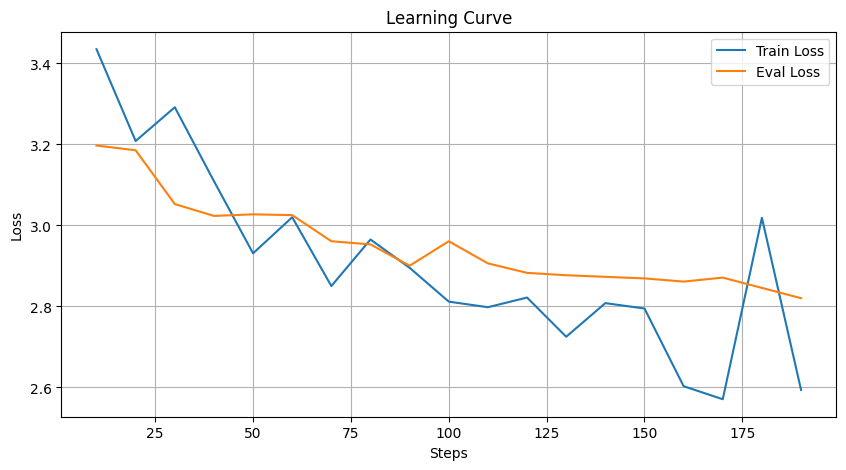

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(trainer):
    logs = trainer.state.log_history
    train_loss = [entry["loss"] for entry in logs if "loss" in entry]
    eval_loss = [entry["eval_loss"] for entry in logs if "eval_loss" in entry]
    steps = [entry["step"] for entry in logs if "loss" in entry]

    plt.figure(figsize=(10, 5))
    plt.plot(steps, train_loss, label="Train Loss")
    if eval_loss:
        eval_steps = [entry["step"] for entry in logs if "eval_loss" in entry]
        plt.plot(eval_steps, eval_loss, label="Eval Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curves(trainer)

In [ ]:
def generate_sequence(target_text):
    prompt = f"serotype: {target_text}"
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)

    # Generate sequences
    output_ids = model.generate(
        input_ids=input_ids,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.8,
        max_length=128,
        num_return_sequences=3,
        repetition_penalty=1.8,
    )

    # Decode and clean results
    print(f"Serotype {target_text}:")
    for i, out in enumerate(output_ids):
        decoded = tokenizer.decode(out, skip_special_tokens=False)
        print(decoded)
        # peptide, inhibition = decoded.split("| inhibition")
        # peptide = decoded.replace(" ", "")
        # inhibition = float(inhibition.strip())
        # print(f"[{i+1}] Generated Peptide: {peptide} | Inhibition: {inhibition}")
    print()

generate_sequence("1")
# generate_sequence("2")
# generate_sequence("3")
# generate_sequence("4")

Serotype 1:
<pad> <extra_id_93> A K W F A F C A Y L S Y H S G A T C G N R K K I V S G L V L D K G L I C G N N A K F A C E M <extra_id_73> </s>
<pad> <extra_id_34> L G W S G S M F C G A L G E N V T I R D K G C V D K K K S F Y <extra_id_67> </s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
<pad><unk>L K R X L I H A I T T P T V K M L <extra_id_70> </s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

